In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random

In [2]:
# Neural Network for the REINFORCE Agent
class ReinforceNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

# REINFORCE Agent
class ReinforceAgent:
    def __init__(self, model, learning_rate=0.005, gamma=0.99, batch_size=8, epsilon = 0.1):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.batch_size = batch_size
        self.saved_log_probs = []
        self.rewards = []
        self.epsilon = epsilon

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.model(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
    
    """def select_action(self, state):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.model(state_tensor)
        m = torch.distributions.Categorical(probs)

        if random.random() < self.epsilon:
            # Exploration: choose a random action
            action = random.choice(range(n_outputs))  # Assuming n_outputs is the number of possible actions
        else:
            # Exploitation: choose the best action based on the policy
            action = m.sample()
            action = action.item()

        action_tensor = torch.tensor([action], dtype=torch.int64)  # Convert action to tensor
        self.saved_log_probs.append(m.log_prob(action_tensor))
        return action"""

    def finish_episode(self):
        R = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-6)  # Normalize returns
        
        for log_prob, R in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        policy_loss = torch.cat(policy_loss).sum()
        return policy_loss

    def update_model(self, policy_loss):
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # Reset rewards and saved actions
        del self.rewards[:]
        del self.saved_log_probs[:]

# Function to save the model
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

# Function to load the model
def load_model(model, filename):
    model.load_state_dict(torch.load(filename))
    model.eval()

# Initialize environment and agent
env = gym.make("LunarLander-v2", continuous=False)
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

# Create the agent
reinforce_net = ReinforceNetwork(n_inputs, n_outputs)
agent = ReinforceAgent(reinforce_net, learning_rate=0.005, gamma=0.99, batch_size=8)

# For demonstration, I will reduce the max_episodes to a lower number
# max_episodes = 5000
max_episodes = 800  # For demonstration

# Lists to store rewards and loss for plotting
episode_rewards = []
mean_rewards = []
losses = []

# Training loop
for episode in range(max_episodes):
    state = env.reset()
    ep_reward = 0
    done = False
    while not done:
        actual_state = state[0] if isinstance(state, tuple) else state
        action = agent.select_action(actual_state)

        next_state = env.step(action)
        reward = next_state[1]
        done = next_state[2]
        agent.rewards.append(reward)
        ep_reward += reward
        state = next_state

    # Update model if batch is completed or it's the last episode
    if (episode + 1) % agent.batch_size == 0 or episode == max_episodes - 1:
        policy_loss = agent.finish_episode()
        agent.update_model(policy_loss)
        losses.append(policy_loss.item())

    episode_rewards.append(ep_reward)

    # Calculate mean reward for the last 100 episodes
    if episode >= 100:
        mean_reward = np.mean(episode_rewards[-100:])
        mean_rewards.append(mean_reward)
    else:
        mean_rewards.append(np.mean(episode_rewards))

    # Print progress
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {mean_rewards[-1]}")

# Save the model
model_filename = 'reinforce_agent_model.pth'
save_model(agent.model, model_filename)

# Close the environment
env.close()




Episode 0, Average Reward: -84.75226550185099
Episode 10, Average Reward: -187.65630760488057
Episode 20, Average Reward: -164.07121012977873
Episode 30, Average Reward: -165.1469432707047


: 

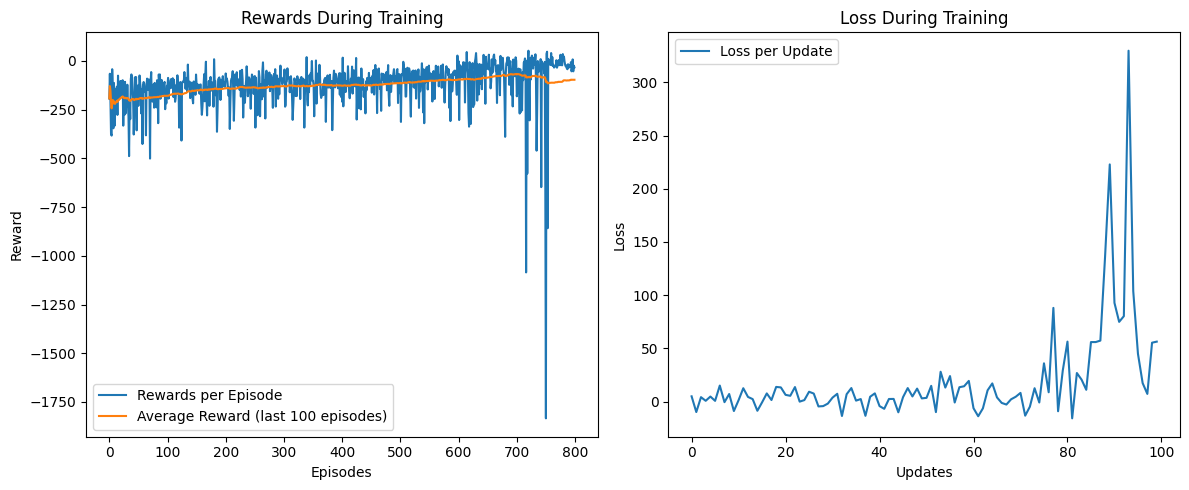

In [ ]:
# Now, let's plot the rewards and losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, label="Rewards per Episode")
plt.plot(mean_rewards, label="Average Reward (last 100 episodes)")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Rewards During Training")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses, label="Loss per Update")
plt.xlabel("Updates")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cargar el modelo entrenado
reinforce_net_eval = ReinforceNetwork(n_inputs, n_outputs)
load_model(reinforce_net_eval, 'reinforce_agent_model.pth')

# Evaluar el modelo entrenado
env = gym.make("LunarLander-v2", continuous=False)
total_rewards = []

for episode in range(100):
    state = env.reset()
    total_ep_reward = 0
    done = False
    while not done:
        state_array = state[0] if isinstance(state, tuple) else state
        #state_array = np.array(state) if isinstance(state, tuple) else state
        state_tensor = torch.from_numpy(state_array).float().unsqueeze(0)
        action_probs = reinforce_net_eval(state_tensor)
        action = torch.argmax(action_probs).item()

        next_state = env.step(action)
        reward = next_state[1]
        done = next_state[2]
        total_ep_reward += reward
        state = next_state
    total_rewards.append(total_ep_reward)

"""for episode in range(100):
    state = env.reset()
    print("Initial state structure:", state)  # Imprimir la estructura del estado inicial
    total_ep_reward = 0
    done = False
    while not done:
        if isinstance(state, tuple):
            print("State structure in the loop:", state)  # Imprimir la estructura del estado en el bucle
            # Aquí iría la lógica para manejar la tupla
            # Por ejemplo: state_array = np.array(state[0]) si sabes que el primer elemento es el que necesitas
        else:
            state_array = state

        state_tensor = torch.from_numpy(state_array).float().unsqueeze(0)
        action_probs = reinforce_net_eval(state_tensor)
        action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
        total_ep_reward += reward

    total_rewards.append(total_ep_reward)"""




        

env.close()

# Graficar las recompensas durante la evaluación
plt.figure(figsize=(10, 6))
plt.plot(total_rewards, label="Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Performance of Trained Agent Over 100 Episodes")
plt.legend()
plt.show()


KeyboardInterrupt: 